# 실습 1. basic model and XOR

이 실습에서는 Keras를 이용하여 실제 신경망 모델을 설계하고 학습하는 방법을 배웁니다.

그리고 XOR 연산을 신경망이 어떻게 학습하는지 볼 것입니다.

### 화면을 전체 폭의 90%로, 최대한 넓게 사용하도록 합니다. 최대 100%까지 설정할 수 있습니다.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important;}</style>"))

## 0. 필요한 모듈들을 불러옵니다.
* keras는 Keras 라이브러리로, 바탕에 tensorflow를 사용합니다.
* numpy는 Python용 수학 라이브러리로 행렬 연산 등에 사용하기 편리합니다.
* matplotlib.pyplot는 가장 널리 사용되는 plotting 라이브러리 중 하나입니다.

In [2]:
import keras
import keras.backend as K
import keras.layers as Layers
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


## A. 무작위 데이터 + FNN w. 1 hidden layer

## 1. 데이터를 준비합니다.

학습을 위해 필요한 데이터를 준비하는 것은 어쩌면 신경망 활용에 있어서 가장 중요한 일입니다.

우선은 무작위 데이터를 준비해 봅시다. 신경망의 입력은 $[-10, 10]$ 구간의 실수 두 개, 출력은 $[-1, 1]$ 구간의 실수 한 개로 가정하고 총 100 쌍을 준비하면 데이터의 모양은 다음처럼 됩니다.

* 입력자료 : #columns = 2, #rows = 100
* 출력자료 : #columns = 1, #rows = 100

무작위 데이터를 만들기 위해 **np.random.rand(num_data)** 함수를 사용합니다. 이것은 $[0, 1]$ 사이 임의의 난수를 num_data 개 생성합니다.

In [20]:
num_data = 100

x = np.random.rand(2 * num_data).reshape((100, 2)) * 20 - 10
y = np.random.rand(num_data) * 2 - 1
print('x = ', x[:10])
print('y = ', y[:10])

x =  [[-6.97372497 -9.0831536 ]
 [ 2.41196147  0.23160304]
 [-6.50924806 -2.36042549]
 [-5.09961295  8.11060017]
 [-2.22696141 -8.655698  ]
 [-9.56854783  7.08301386]
 [-1.92889473 -4.99977159]
 [ 4.95564505  0.6709079 ]
 [-2.97633392  5.68731342]
 [ 0.49899015  6.59750369]]
y =  [ 0.83257168  0.77591328 -0.25431792 -0.25663443  0.28235645  0.03739923
  0.79546478  0.4695232  -0.75136833 -0.8098197 ]


## 2. 모델을 만듭니다.

모델을 생성하기 위한 코드입니다. 여기서는 dense layer를 두 개 쌓은 단순한 모델을 사용합니다. 따라서 hidden layer는 1개입니다.

* Dense layer는 신경망 구조 그림에서 많이 보던 것으로, 아래 층과 촘촘하게 이어져 있는 layer를 말합니다. Fully-connected layer(F.C. layer)라고 부르기도 합니다.

모델의 입력은 $x$이므로 입력의 shape는 $(2,)$입니다. (입력의 shape를 지정할 때 데이터의 총 개수는 고려하지 않습니다.)

입력 layer의 이름은 지정하지 않아도 되지만 여기서는 'input_layer'로 주었습니다.

In [17]:
input_layer = Layers.Input(shape = (2, ), name = 'input_layer')

첫 번째 hidden layer는 input_layer를 입력으로 삼으며 cell 2개로 이루어집니다. 이름은 'hidden_layer'로 했습니다.

activation은 활성화 함수를 가리킵니다.

In [18]:
hidden_layer = Layers.Dense(units= 2, activation='tanh', name = 'hidden_layer')(input_layer)

출력 layer는 $y$에 대응해야 하므로 cell 1개로 이루어집니다. 이름은 'output_layer'입니다.

In [23]:
output_layer = Layers.Dense(units = 1, name = 'output_layer')(hidden_layer)

입력에서 출력까지 순서대로 잘 이어져 있는 모습을 머리 속에서 그릴 수 있을 것입니다.
$$ {\rm{input\_layer}} \rightarrow {\rm hidden\_layer} \rightarrow {\rm output\_layer} $$
이제 입력과 출력을 이어 모델을 만듭니다.

In [25]:
model = keras.Model(input_layer, output_layer)

# summary로 모델의 전체 모습을 간단하게 볼 수 있습니다.
model.summary(100)

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_layer (InputLayer)                     (None, 2)                               0              
____________________________________________________________________________________________________
hidden_layer (Dense)                         (None, 2)                               6              
____________________________________________________________________________________________________
output_layer (Dense)                         (None, 1)                               3              
Total params: 9
Trainable params: 9
Non-trainable params: 0
____________________________________________________________________________________________________


## 3. 이제 학습을 진행할 차례입니다.

실제 학습을 위해서는 모델을 만든 것으로 끝나지 않습니다. 이 모델이 어떤 loss를 사용하는지, 그리고 어떤 optimizer를 이용해서 학습할 것인지 지정해야 합니다.

* 우리 경우에는 실제 결과 $y$ 및 모델의 출력 $\hat{y}$가 모두 하나의 실수이므로, loss로 mean squared error를 사용합니다.

$$ MSE\left(y, \hat{y} \right) = \left|\ y - \hat{y} \ \right| ^ 2 $$

* optimizer는 Gradient Descent를 적용하는 방법(특히 learning rate $\alpha$)과 관련된 것입니다. 여기서는 rmsprop를 사용합니다.
    * optimizer에 따라 학습의 양상(학습의 효율성 등)이 바뀔 수 있습니다.

In [29]:
model.compile(optimizer = 'rmsprop', loss = 'mse')

실제 학습을 해 봅시다. 학습을 위해서는 fit 함수를 사용합니다.

In [31]:
model.fit(x = x, y = y, epochs= 10)

Epoch 1/10
100/100 [==============================] - 0s 100us/step - loss: 0.3598
Epoch 2/10
100/100 [==============================] - 0s 100us/step - loss: 0.3588
Epoch 3/10
100/100 [==============================] - 0s 100us/step - loss: 0.3585
Epoch 4/10
100/100 [==============================] - 0s 100us/step - loss: 0.3579
Epoch 5/10
100/100 [==============================] - 0s 100us/step - loss: 0.3571
Epoch 6/10
100/100 [==============================] - 0s 100us/step - loss: 0.3568
Epoch 7/10
100/100 [==============================] - 0s 140us/step - loss: 0.3565
Epoch 8/10
100/100 [==============================] - 0s 150us/step - loss: 0.3558
Epoch 9/10
100/100 [==============================] - 0s 150us/step - loss: 0.3557
Epoch 10/10
100/100 [==============================] - 0s 130us/step - loss: 0.3553


학습된 결과 모델은 **model.save** 또는 **model.save_weights** 함수를 이용해서 저장할 수 있고, **model.load_weights** 함수를 이용해서 불러올 수 있습니다. 자세한 것은 **help(keras.Model.save)**, **help(keras.Model.load_weights)** 등을 참고하시기 바랍니다.

In [34]:
model.save('test_model.hdf5')
model.load_weights('test_model.hdf5')

모델을 통과한 결과인 $\hat{y}$의 값을 보려면 **predict** 함수를 사용합니다. 결과가 그다지 좋지는 않습니다.

In [37]:
y_hat = model.predict(x)
print(y_hat[:10])

[[-0.01048115]
 [-0.02213722]
 [-0.01048157]
 [-0.02532431]
 [-0.01048115]
 [-0.02651636]
 [-0.01048108]
 [-0.0251899 ]
 [-0.02533332]
 [-0.02532377]]


## B. XOR 데이터 + FNN w. 1 hidden layer

## 1. 데이터를 준비합니다.

이번에는 XOR 연산을 학습하도록 만들어 봅니다.

신경망의 입력은 거짓/참에 대응하는 0 또는 1 값 두 개, 출력은 입력값 두 개의 XOR이므로 0 또는 1 값 1개입니다. 총 100 쌍을 준비하면 데이터의 모양은 다음처럼 됩니다.

* 입력자료 : #columns = 2, #rows = 100
* 출력자료 : #columns = 1, #rows = 100

In [289]:
num_data = 100

x_orig = np.random.rand(2 * num_data).reshape((num_data, -1))
x_logic = x_orig > 0.5
x = np.asarray(x_logic, dtype=int)
y_logic = x_logic[:, 0] ^ x_logic[:, 1]
y = np.asarray(y_logic, dtype=int)
print('x_logic = ', x_logic[:10])
print('x = ', x[:10])
print('y = ', y[:10])

x_logic =  [[False  True]
 [ True  True]
 [ True False]
 [False False]
 [False  True]
 [ True False]
 [ True False]
 [False False]
 [False False]
 [ True False]]
x =  [[0 1]
 [1 1]
 [1 0]
 [0 0]
 [0 1]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [1 0]]
y =  [1 0 1 0 1 1 1 0 0 1]


## 2. 모델을 만듭니다.

모델을 생성하기 위한 코드입니다. 여기서는 dense layer를 두 개 쌓은 단순한 모델을 사용합니다. 따라서 hidden layer는 1개입니다.

* Dense layer는 신경망 구조 그림에서 많이 보던 것으로, 아래 층과 촘촘하게 이어져 있는 layer를 말합니다. Fully-connected layer(F.C. layer)라고 부르기도 합니다.

만드는 과정은 **A**와 완전히 동일하므로 설명은 생략합니다.

In [304]:
input_layer = Layers.Input(shape = (2, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 2, activation='tanh', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 1, activation='tanh', name = 'output_layer')(hidden_layer)

xor_model = keras.Model(input_layer, output_layer)

# summary로 모델의 전체 모습을 간단하게 볼 수 있습니다.
xor_model.summary(100)

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_layer (InputLayer)                     (None, 2)                               0              
____________________________________________________________________________________________________
hidden_layer (Dense)                         (None, 2)                               6              
____________________________________________________________________________________________________
output_layer (Dense)                         (None, 1)                               3              
Total params: 9
Trainable params: 9
Non-trainable params: 0
____________________________________________________________________________________________________


## 3. 이제 학습을 진행할 차례입니다.

실제 학습을 위해서는 모델을 만든 것으로 끝나지 않습니다. 이 모델이 어떤 loss를 사용하는지, 그리고 어떤 optimizer를 이용해서 학습할 것인지 지정해야 합니다.

* 우리 경우에는 실제 결과 $y$ 및 모델의 출력 $\hat{y}$가 모두 하나의 실수이므로, loss로 mean squared error를 사용합니다.

$$ MSE\left(y, \hat{y} \right) = \left|\ y - \hat{y} \ \right| ^ 2 $$

* optimizer는 Gradient Descent를 적용하는 방법(특히 learning rate $\alpha$)과 관련된 것입니다. 여기서는 rmsprop을 사용합니다.
    * optimizer에 따라 학습의 양상(학습의 효율성 등)이 바뀔 수 있습니다.

In [305]:
xor_model.save_weights('base_weight.hdf5')

xor_model.compile(optimizer = 'rmsprop', loss = 'mse')
xor_model.fit(x = x, y = y, initial_epoch=0, epochs= 100)

Epoch 1/100
100/100 [==============================] - 3s 29ms/step - loss: 0.4953
Epoch 2/100
100/100 [==============================] - 0s 230us/step - loss: 0.4817
Epoch 3/100
100/100 [==============================] - 0s 210us/step - loss: 0.4735
Epoch 4/100
100/100 [==============================] - 0s 200us/step - loss: 0.4692
Epoch 5/100
100/100 [==============================] - 0s 210us/step - loss: 0.4645
Epoch 6/100
100/100 [==============================] - 0s 210us/step - loss: 0.4584
Epoch 7/100
100/100 [==============================] - 0s 200us/step - loss: 0.4539
Epoch 8/100
100/100 [==============================] - 0s 210us/step - loss: 0.4472
Epoch 9/100
100/100 [==============================] - 0s 215us/step - loss: 0.4412
Epoch 10/100
100/100 [==============================] - 0s 201us/step - loss: 0.4367
Epoch 11/100
100/100 [==============================] - 0s 210us/step - loss: 0.4320
Epoch 12/100
100/100 [==============================] - 0s 210us/step - los

100/100 [==============================] - 0s 160us/step - loss: 0.2212
Epoch 98/100
100/100 [==============================] - 0s 140us/step - loss: 0.2199
Epoch 99/100
100/100 [==============================] - 0s 160us/step - loss: 0.2184
Epoch 100/100
100/100 [==============================] - 0s 140us/step - loss: 0.2170


모델을 통과한 결과인 $\hat{y}$의 값을 보려면 **predict** 함수를 사용합니다.

In [306]:
y_hat = xor_model.predict(x)
print(y_hat[:10], y[:10])

[[0.45245066]
 [0.8530972 ]
 [0.93637395]
 [0.13403305]
 [0.45245066]
 [0.93637395]
 [0.93637395]
 [0.13403305]
 [0.13403305]
 [0.93637395]] [1 0 1 0 1 1 1 0 0 1]


학습 결과를 확인하기 위해서는 $\hat{y}$의 값을 0.5 기준으로 나눠서 1, 0으로 대응시켜 $y$와 비교해보면 될 것 같은데, 생각보다 잘 맞지 않습니다. 얼마나 맞는지 계산해 봅시다.

In [307]:
accuracy_m1_e100 = np.mean(np.equal(y_hat[:, 0] > 0.5, (y > 0.5)))
print('정확도 = ', accuracy_m1_e100)

정확도 =  0.6


생각보다 정확도가 낮습니다. 학습 횟수를 늘려보면 좀 낫겠죠.

In [308]:
xor_model.load_weights('base_weight.hdf5')

xor_model.fit(x = x, y = y, initial_epoch=0, epochs = 1000, verbose = 0)
y_hat = xor_model.predict(x)

print(y_hat[:10], y[:10])
print(y_hat[:10] > 0.5, y[:10] > 0.5)

accuracy_m1_e1000 = np.mean(np.equal(y_hat[:, 0] > 0.5, (y > 0.5)))
print('정확도 = ', accuracy_m1_e1000)

[[ 0.4694724 ]
 [ 0.47347876]
 [ 0.9570908 ]
 [-0.00323742]
 [ 0.4694724 ]
 [ 0.9570908 ]
 [ 0.9570908 ]
 [-0.00323742]
 [-0.00323742]
 [ 0.9570908 ]] [1 0 1 0 1 1 1 0 0 1]
[[False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]] [ True False  True False  True  True  True False False  True]
정확도 =  0.81


좀 낫네요. 은닉층이 1개 있으면 XOR을 모사할 수 있다는 것을 알았습니다.

그런데 꼭 1000번이나 학습시켜야 할까 싶습니다. 다른 방법을 찾아봅시다.

### 우선 모델을 살짝 바꿔봅니다. 활성화 함수를 좀 바꿔볼까요.

In [309]:
input_layer = Layers.Input(shape = (2, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 2, activation='relu', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 1, activation='relu', name = 'output_layer')(hidden_layer)

xor_model2 = keras.Model(input_layer, output_layer)
xor_model2.compile(optimizer = 'rmsprop', loss = 'mse')
xor_model2.load_weights('base_weight.hdf5')

xor_model2.fit(x = x, y = y, initial_epoch=0, epochs = 100, verbose = 0)
y_hat = xor_model2.predict(x)

accuracy_m2_e100 = np.mean(np.equal(y_hat[:, 0] > 0.5, (y > 0.5)))
print('정확도 = ', accuracy_m2_e100)

정확도 =  0.6


시원치 않습니다. **relu**를 **tanh**로 바꾸던 그 반대로 하던 비슷합니다. 그럼 hiddeh layer의 구조를 좀 바꿔봅시다. 우선은 cell의 개수를 늘리는 쪽으로.

In [310]:
input_layer = Layers.Input(shape = (2, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 20, activation='tanh', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 1, activation='tanh', name = 'output_layer')(hidden_layer)

xor_model3 = keras.Model(input_layer, output_layer)
xor_model3.summary()
xor_model3.compile(optimizer = 'rmsprop', loss = 'mse')

xor_model3.fit(x = x, y = y, initial_epoch=0, epochs = 100, verbose = 0)
y_hat = xor_model3.predict(x)

accuracy_m3_e100 = np.mean(np.equal(y_hat[:, 0] > 0.5, (y > 0.5)))
print('정확도 = ', accuracy_m3_e100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 2)                 0         
_________________________________________________________________
hidden_layer (Dense)         (None, 20)                60        
_________________________________________________________________
output_layer (Dense)         (None, 1)                 21        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
정확도 =  0.79


대부분의 시도에서 성능이 좋아질 것입니다. 다음은 hidden layer의 수를 늘려봅시다.

In [311]:
input_layer = Layers.Input(shape = (2, ), name = 'input_layer')
hidden_layer1 = Layers.Dense(units= 20, activation='tanh', name = 'hidden_layer1')(input_layer)
hidden_layer2 = Layers.Dense(units= 20, activation='tanh', name = 'hidden_layer2')(hidden_layer1)
output_layer = Layers.Dense(units = 1, activation='tanh', name = 'output_layer')(hidden_layer2)

xor_model4 = keras.Model(input_layer, output_layer)
xor_model4.summary()
xor_model4.compile(optimizer = 'rmsprop', loss = 'mse')

xor_model4.fit(x = x, y = y, initial_epoch=0, epochs = 100, verbose = 0)
y_hat = xor_model4.predict(x)
print(y_hat[:10])
print(y[:10])

accuracy_m4_e100 = np.mean(np.equal(y_hat[:, 0] > 0.5, (y > 0.5)))
print('정확도 = ', accuracy_m4_e100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 2)                 0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 20)                60        
_________________________________________________________________
hidden_layer2 (Dense)        (None, 20)                420       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 21        
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
[[0.6473815 ]
 [0.42517063]
 [0.69533193]
 [0.14740579]
 [0.6473815 ]
 [0.69533193]
 [0.69533193]
 [0.14740579]
 [0.14740579]
 [0.69533193]]
[1 0 1 0 1 1 1 0 0 1]
정확도 =  1.0


모델을 키우는 것은 좋지만, 우리는 원래 모델 - hidden layer는 1개뿐이고, 거기에는 cell이 2개 - 이면 XOR를 모사하는데 충분하다는 것을 알고 있습니다.

이 모델로 XOR를 잘 학습하려면 epoch을 늘리는 해결책이 있다는 건 알지만, 다른 방법은 없을까요?

### optimizer를 잘 선택하는 것도 중요합니다.

원래 모델로 돌아가서 optimizer만 adam으로 바꿔봅니다.

In [312]:
input_layer = Layers.Input(shape = (2, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 2, activation='tanh', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 1, activation='tanh', name = 'output_layer')(hidden_layer)

xor_model5 = keras.Model(input_layer, output_layer)
xor_model5.compile(optimizer = 'adam', loss = 'mse')
xor_model5.load_weights('base_weight.hdf5')

xor_model5.fit(x = x, y = y, initial_epoch=0, epochs= 100)

y_hat = xor_model5.predict(x)

accuracy_m5_e100 = np.mean(np.equal(y_hat[:, 0] > 0.5, (y > 0.5)))
print('정확도 = ', accuracy_m5_e100)

Epoch 1/100
100/100 [==============================] - 3s 30ms/step - loss: 0.4991
Epoch 2/100
100/100 [==============================] - 0s 220us/step - loss: 0.4930
Epoch 3/100
100/100 [==============================] - 0s 210us/step - loss: 0.4872
Epoch 4/100
100/100 [==============================] - 0s 210us/step - loss: 0.4813
Epoch 5/100
100/100 [==============================] - 0s 205us/step - loss: 0.4762
Epoch 6/100
100/100 [==============================] - 0s 185us/step - loss: 0.4709
Epoch 7/100
100/100 [==============================] - 0s 220us/step - loss: 0.4649
Epoch 8/100
100/100 [==============================] - 0s 210us/step - loss: 0.4588
Epoch 9/100
100/100 [==============================] - 0s 170us/step - loss: 0.4533
Epoch 10/100
100/100 [==============================] - 0s 200us/step - loss: 0.4482
Epoch 11/100
100/100 [==============================] - 0s 220us/step - loss: 0.4419
Epoch 12/100
100/100 [==============================] - 0s 210us/step - los

100/100 [==============================] - 0s 170us/step - loss: 0.2449
Epoch 98/100
100/100 [==============================] - 0s 140us/step - loss: 0.2439
Epoch 99/100
100/100 [==============================] - 0s 170us/step - loss: 0.2430
Epoch 100/100
100/100 [==============================] - 0s 170us/step - loss: 0.2419
정확도 =  0.6


In [313]:
input_layer = Layers.Input(shape = (2, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 2, activation='tanh', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 1, activation='tanh', name = 'output_layer')(hidden_layer)

xor_model6 = keras.Model(input_layer, output_layer)
xor_model6.compile(optimizer = 'sgd', loss = 'mse')
xor_model6.load_weights('base_weight.hdf5')

xor_model6.fit(x = x, y = y, initial_epoch=0, epochs= 100)

y_hat = xor_model6.predict(x)

accuracy_m6_e100 = np.mean(np.equal(y_hat[:, 0] > 0.5, (y > 0.5)))
print('정확도 = ', accuracy_m6_e100)

Epoch 1/100
100/100 [==============================] - 3s 31ms/step - loss: 0.4942
Epoch 2/100
100/100 [==============================] - 0s 170us/step - loss: 0.4641
Epoch 3/100
100/100 [==============================] - 0s 210us/step - loss: 0.4382
Epoch 4/100
100/100 [==============================] - 0s 190us/step - loss: 0.4264
Epoch 5/100
100/100 [==============================] - 0s 180us/step - loss: 0.4094
Epoch 6/100
100/100 [==============================] - 0s 201us/step - loss: 0.3949
Epoch 7/100
100/100 [==============================] - 0s 170us/step - loss: 0.3815
Epoch 8/100
100/100 [==============================] - 0s 210us/step - loss: 0.3695
Epoch 9/100
100/100 [==============================] - 0s 200us/step - loss: 0.3588
Epoch 10/100
100/100 [==============================] - 0s 200us/step - loss: 0.3467
Epoch 11/100
100/100 [==============================] - 0s 172us/step - loss: 0.3415
Epoch 12/100
100/100 [==============================] - 0s 200us/step - los

100/100 [==============================] - 0s 152us/step - loss: 0.1894
Epoch 98/100
100/100 [==============================] - 0s 160us/step - loss: 0.1888
Epoch 99/100
100/100 [==============================] - 0s 130us/step - loss: 0.1881
Epoch 100/100
100/100 [==============================] - 0s 140us/step - loss: 0.1874
정확도 =  0.79


### optimizer에 따른 학습 곡선(loss를 도시한 것)의 차이는 아래와 같습니다.

학습 과정에서 데이터를 섞기 때문에 각 optimizer가 겪는 상황은 똑같지 않습니다. 따라서 아래 곡선은 공정한 비교는 아닙니다. 게다가 아직 학습할 여지가 많이 남아서(즉, epoch을 늘리면 더 좋은 성능을 낼 수 있기 때문에) 학습 곡선을 더 그려볼 필요가 있습니다.

그러나 각 학습방법에 차이가 있다는 점을 느끼기에는 충분합니다.

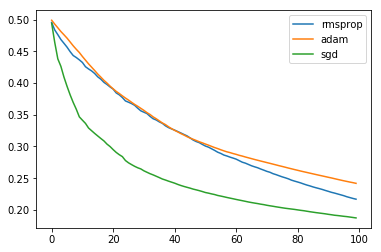

In [315]:
plt.plot(xor_model.history.history['loss'][:100])
plt.plot(xor_model5.history.history['loss'][:100])
plt.plot(xor_model6.history.history['loss'][:100])
plt.legend(['rmsprop', 'adam', 'sgd'])

흠. 아예 1000 epoch까지 그려서 비교해볼까요? 확실히 세 방법의 행동이 다른 게 잘 보입니다.

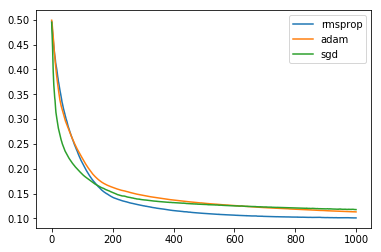

In [316]:
xor_model.load_weights('base_weight.hdf5')
xor_model.fit(x = x, y = y, initial_epoch=0, epochs=1000, verbose = 0)

xor_model5.load_weights('base_weight.hdf5')
xor_model5.fit(x = x, y = y, initial_epoch=0, epochs=1000, verbose = 0)

xor_model6.load_weights('base_weight.hdf5')
xor_model6.fit(x = x, y = y, initial_epoch=0, epochs=1000, verbose = 0)

plt.plot(xor_model.history.history['loss'][:1000])
plt.plot(xor_model5.history.history['loss'][:1000])
plt.plot(xor_model6.history.history['loss'][:1000])
plt.legend(['rmsprop', 'adam', 'sgd'])

여태까지 내용을 잘 보면, 한 가지 사실이 눈에 띕니다.

#### "loss와 accuracy는 관련이 있지만 정확하게 비례하는 값이 아닙니다."

따라서 학습 진행에 따른 accuracy도 확인해 보는 것이 필요합니다.

* **Keras**는 학습 과정에서 metric으로 'accuracy'를 지정할 수 있습니다.
* 우리 학습 자료 $y$는 1개의 실수값이며, loss를 MSE로 했기 때문에 여태까지 우리는 이 값을 계산하라고 지정할 수 없었습니다.
    * **Keras** 입장에서는 이렇게 설정된 상황에서 accuracy를 계산할 방법이 없습니다. MSE로 두 값을 비교하고 있는데 '정확도'라니...?
* 따라서 이번에는 같은 내용을 학습하면서 accuracy를 계산할 수 있도록 학습 자료 및 loss를 바꿔 볼 것입니다.    

### 데이터를 좀 조작해봅시다.

실수값 1개로 나오는 $y$를, 간단한 probability distribution으로 바꿔봅니다. 즉, 0은 $[1, 0]$으로 바꾸고 1은 $[0, 1]$로 바꿉니다. 
* 이런 식으로 category 형식의 값을 한 entry만 1이고 나머지가 0인 vector로 바꾼 것을 **one-hot vector**라고 합니다.

In [318]:
y_prob = keras.utils.to_categorical(y, 2)
print(y[:10])
print(y_prob[:10])

[1 0 1 0 1 1 1 0 0 1]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


이렇게 바꾼 $y_{prob}$로 학습하려면 모델 구조를 좀 바꿔야합니다.

* 출력 layer의 cell은 두 개가 되어야 합니다.
* 또한 이것을 확률분포로 바꾸기 위해 softmax layer를 추가해야 합니다.
    * softmax layer는 고정된 연산을 수행하므로 학습할 파라메터가 없는 layer입니다.
    
* 또한 loss는 이제 하나의 값이 아닌 확률분포를 비교하는 것이므로 'categorical_crossentropy'가 됩니다.

In [336]:
input_layer = Layers.Input(shape = (2, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 2, activation='tanh', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 2, activation='softmax', name = 'output_layer')(hidden_layer)

xor_model_a1 = keras.Model(input_layer, output_layer)
xor_model_a1.summary()

xor_model_a1.save_weights('base_weight_a1.hdf5')

xor_model_a1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

xor_model_a1.fit(x = x, y = y_prob, initial_epoch=0, epochs = 2000, verbose = 0)
y_hat = xor_model_a1.predict(x)

print(y_hat[:10])
print(y_prob[:10])

accuracy_a1_e100 = np.mean(np.equal(y_hat[:, 1] > 0.5, (y_prob[:, 1] > 0.5)))
print('정확도 = ', accuracy_a1_e100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 2)                 0         
_________________________________________________________________
hidden_layer (Dense)         (None, 2)                 6         
_________________________________________________________________
output_layer (Dense)         (None, 2)                 6         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
[[0.00869957 0.9913004 ]
 [0.38867736 0.61132264]
 [0.38883892 0.6111611 ]
 [0.9939102  0.00608982]
 [0.00869957 0.9913004 ]
 [0.38883892 0.6111611 ]
 [0.38883892 0.6111611 ]
 [0.9939102  0.00608982]
 [0.9939102  0.00608982]
 [0.38883892 0.6111611 ]]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
정확도 =  0.79


In [337]:
input_layer = Layers.Input(shape = (2, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 2, activation='tanh', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 2, activation='softmax', name = 'output_layer')(hidden_layer)

xor_model_a2 = keras.Model(input_layer, output_layer)
xor_model_a2.summary()
xor_model_a2.load_weights('base_weight_a1.hdf5')
xor_model_a2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
xor_model_a2.fit(x = x, y = y_prob, initial_epoch=0, epochs = 2000, verbose = 0)

xor_model_a3 = keras.Model(input_layer, output_layer)
xor_model_a3.summary()
xor_model_a3.load_weights('base_weight_a1.hdf5')
xor_model_a3.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
xor_model_a3.fit(x = x, y = y_prob, initial_epoch=0, epochs = 2000, verbose = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 2)                 0         
_________________________________________________________________
hidden_layer (Dense)         (None, 2)                 6         
_________________________________________________________________
output_layer (Dense)         (None, 2)                 6         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 2)                 0         
_________________________________________________________________
hidden_layer (Dense)         (None, 2)                 6         
_________________________________________________________________
output_layer (

accuracy를 비교 도시해 보면 아래와 같습니다. loss의 상대적인 높고 낮음이 accuracy의 상대적인 낮고 높음과 정확히 일치하지 않는 것을 확인할 수 있습니다.

따라서 학습 과정에는 loss를 신경쓰되, 학습된 모델을 사용할 때는 accuracy를 신경쓰는 것이 좋습니다.

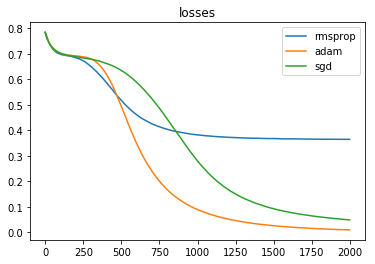

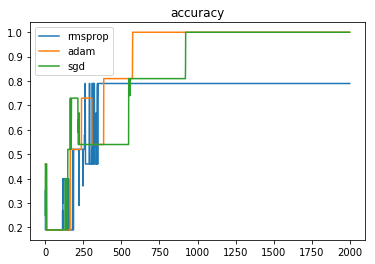

In [338]:
plt.plot(xor_model_a1.history.history['loss'][:2000])
plt.plot(xor_model_a2.history.history['loss'][:2000])
plt.plot(xor_model_a3.history.history['loss'][:2000])
plt.legend(['rmsprop', 'adam', 'sgd'])
plt.title('losses')
plt.show()

plt.plot(xor_model_a1.history.history['acc'][:2000])
plt.plot(xor_model_a2.history.history['acc'][:2000])
plt.plot(xor_model_a3.history.history['acc'][:2000])
plt.legend(['rmsprop', 'adam', 'sgd'])
plt.title('accuracy')
plt.show()